# Saad Khan - 3010290 


## Fake NEWS Detection - Using Liar Dataset & Experimenting results with different classifiers.

In [96]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm
from collections import Counter

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Investigating Fake News Detection with Scikit-Learn

Detecting so-called "fake news" is no easy task. First, there is defining what fake news is -- given it has now become a political statement. If you can find or agree upon a definition, then you must collect and properly label real and fake news (hopefully on similar topics to best show clear distinctions). Once collected, you must then find useful features to determine fake from real news. 

For a more in-depth look at this problem space, I recommend taking a look at Miguel Martinez-Alvarez's post ["How can Machine Learning and AI Help Solve the Fake News Problem"](https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/).

Around the same time I read Miguel's insightful post, I came across an open data science post about [building a successful fake news detector with Bayesian models](https://opendatascience.com/blog/how-to-build-a-fake-news-classification-model/). The author even created a [repository with the dataset of tagged fake and real news examples](https://github.com/GeorgeMcIntire/fake_real_news_dataset). I was curious if I could easily reproduce the results, and if I could then determine what the model had learned. 

In this notebook, we'll walk through some of my initial exploration together and see if you can build a successful fake news detector!

### Data Exploration

To begin, you should always take a quick look at the data and get a feel for its contents. To do so, use a Pandas DataFrame and check the shape, head and apply any necessary transformations.

In [141]:
#df2 = pd.read_csv('./fake_or_real_news.csv')
df = pd.read_csv('./train.tsv',sep='\t', names=['filename', 'label', 'text', 'topic', 'member', 'post','state','party','x','y','z','k','l','type'])
dftest = pd.read_csv('./test.tsv',sep='\t', names=['filename', 'label', 'text', 'topic', 'member', 'post','state','party','x','y','z','k','l','type'])


In [27]:
#df.shape
df.shape
dftest.shape

(1267, 14)

In [134]:
#df.head(20900)
#dftest.head()
#df2.head()

In [29]:
#df = df.set_index('2635.json')
#only taking true & false labeled news for training and validation
df2 = df[df.label == "false"]
df3 = df[df.label == "true"]
dftest2 = dftest[dftest.label == "false"]
dftest3 = dftest[dftest.label == "true"]

In [142]:
#Replacing all values that are not true to false
dfNF.loc[df.label!='true',"label"] = "false"
dfNF_test.loc[dftest.label!='true',"label"] = "false"
#dfNF_test.head(2000)

# Scenario 2 

In [154]:
#Scenario 2 
print(df['label'].value_counts())
print()
dfT.loc[df.label.str.contains("true"),"label"] = "true"
print(dfT['label'].value_counts())
print()
print(dftest['label'].value_counts())
dfT_test.loc[dftest.label.str.contains("true"),"label"] = "true"
print()
print(dfT_test['label'].value_counts())

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

true     7406
false    2834
Name: label, dtype: int64

half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: label, dtype: int64

true     926
false    341
Name: label, dtype: int64


In [123]:
frames = [df2,df3]
f2 = [dftest2,dftest3]
dfR = pd.concat(frames)
dfR = dfR.sample(frac=1)
dftestR = pd.concat(f2)
dftestR = dftestR.sample(frac=1)
#dfR.head(2000)
#dfR.head(2000)

### Extracting the training data

Now that the DataFrame looks closer to what you need, you want to separate the labels and set up training and test datasets. 

For this notebook, I decided to focus on using the longer article text. Because I knew I would be using bag-of-words and Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, this seemed like a good choice. Using longer text will hopefully allow for distinct words and features for my real and fake news data.

In [165]:
y = df.label
test_y = dftest.label
yR = dfR.label
test_yR = dftestR.label
#print(y)
#y = df.iloc[:,1]
yN = dfNF.label
test_yN = dfNF_test.label
yT = dfT.label
test_yT = dfT_test.label
#print(yT)


In [166]:
#
#df = df.drop(0,1)
#df = df.drop(df.columns[0], axis=1)
#df = df.drop(df.columns[1], axis=1)
#df.drop(df.columns[[0, 1]], axis=1, inplace=True)
#dftest.drop(dftest.columns[[0, 1]], axis=1, inplace=True)
#df.head()
#dftest.head()

In [159]:
#X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)
#print(X_train)
#Whole dataset as it is
X_train = df['text']
X_test = dftest['text']
#Only true & false part of dataset
X_trainR = dfR['text']
X_testR = dftestR['text']
#true as true and everything as false part of dataset
X_trainN = dfNF['text']
X_testN = dfNF_test['text']

X_trainT = dfT['text']
X_testT = dfT_test['text']
#print(dftest['text'])
#y_train = y
#y_test = test_y
#print(X_testR)

### Building Vectorizer Classifiers

Now that you have your training and testing data, you can build your classifiers. To get a good idea if the words and tokens in the articles had a significant impact on whether the news was fake or real, you begin by using `CountVectorizer` and `TfidfVectorizer`.  

You'll see the example has a max threshhold set at `.7` for the TF-IDF vectorizer `tfidf_vectorizer` using the `max_df` argument. This removes words which appear in more than 70% of the articles. Also, the built-in `stop_words` parameter will remove English stop words from the data before making vectors. 

There are many more parameters avialable and you can read all about them in the scikit-learn documentation for [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [15]:
#count_vectorizer = CountVectorizer(stop_words='english')
#count_train = count_vectorizer.fit_transform(X_train)
#count_test = count_vectorizer.transform(X_test)

In [162]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#tfidf_R_train = tfidf_vectorizer.fit_transform(X_trainR)
#tfidf_R_test = tfidf_vectorizer.transform(X_testR)


In [163]:
#Scenario 1 
tfidf_train_N = tfidf_vectorizer.fit_transform(X_trainN)
tfidf_test_N = tfidf_vectorizer.transform(X_testN)

In [164]:
#Scenario 1 
tfidf_train_T = tfidf_vectorizer.fit_transform(X_trainT)
tfidf_test_T = tfidf_vectorizer.transform(X_testT)

Now that you have vectors, you can then take a look at the vector features, stored in `count_vectorizer` and `tfidf_vectorizer`. 

Are there any noticable issues? (Yes!)

There are clearly comments, measurements or other nonsensical words as well as multilingual articles in the dataset that you have been using. Normally, you would want to spend more time preprocessing this and removing noise, but as this tutorial just showcases a small proof of concept, we will see if the model can overcome the noise and properly classify despite these issues.

In [46]:
tfidf_vectorizer.get_feature_names()[-10:]

['youve',
 'yuri',
 'zeldin',
 'zephyr',
 'zero',
 'zika',
 'zip',
 'zombie',
 'zombies',
 'zones']

In [22]:
#count_vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '00000031',
 '000035',
 '00006',
 '0001',
 '0001pt',
 '000ft',
 '000km']

In [29]:
#count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [87]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# DTree Classifier 

In [97]:
dtclf = tree.DecisionTreeClassifier()

Counter({'false': 1052, 'true': 215})
accuracy:   0.720
Confusion matrix, without normalization


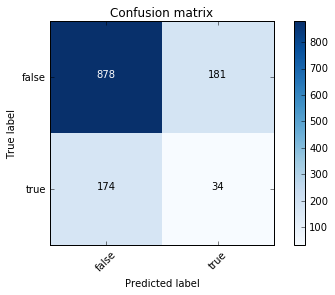

In [98]:
dtclf.fit(tfidf_train_N, yN)
pred = dtclf.predict(tfidf_test_N)
score = metrics.accuracy_score(test_yN, pred)
print(Counter(pred))
#print(score)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yN, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Naive Bayes Classifier

In [38]:
clf = MultinomialNB() 

Counter({'false': 1070, 'true': 197})
accuracy:   0.734
Confusion matrix, without normalization


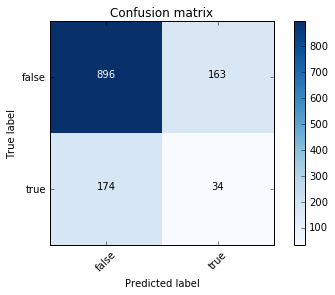

In [99]:
clf.fit(tfidf_train_N, yN)
pred = clf.predict(tfidf_test_N)
score = metrics.accuracy_score(test_yN, pred)
print(Counter(pred))
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yN, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# SVM Classifier

In [ ]:
svmclf = svm.SVC()

Counter({'false': 1267})
accuracy:   0.836
Confusion matrix, without normalization


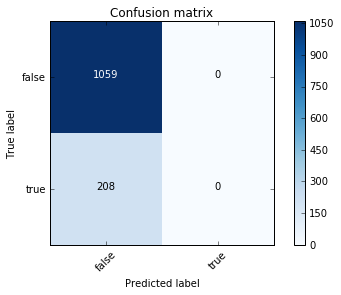

In [100]:
svmclf.fit(tfidf_train_N, yN)
pred = svmclf.predict(tfidf_test_N)
score = metrics.accuracy_score(test_yN, pred)
print(Counter(pred))
#print(score)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yN, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# RForest Classifier

In [ ]:
rfclf = RandomForestClassifier()

Counter({'false': 1225, 'true': 42})
accuracy:   0.812
Confusion matrix, without normalization


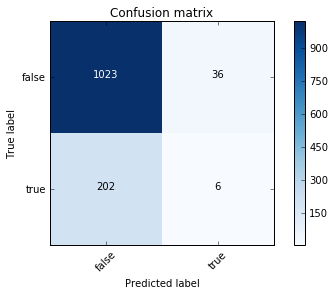

In [101]:
rfclf.fit(tfidf_train_N, yN)
pred = rfclf.predict(tfidf_test_N)
score = metrics.accuracy_score(test_yN, pred)
print(Counter(pred))
#print(score)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yN, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Scenario 2 Classifiers

Counter({'true': 948, 'false': 319})
accuracy:   0.645
Confusion matrix, without normalization


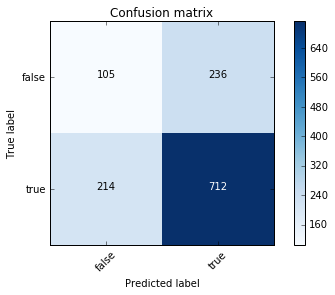

In [167]:
#DT Classifier
dtclf.fit(tfidf_train_T, yT)
pred = dtclf.predict(tfidf_test_T)
score = metrics.accuracy_score(test_yT, pred)
print(Counter(pred))
#print(score)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yT, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

Counter({'true': 948, 'false': 319})
accuracy:   0.650
Confusion matrix, without normalization


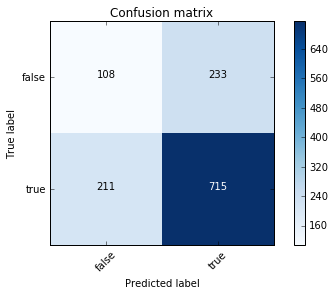

In [168]:
#NaiveBayes
clf.fit(tfidf_train_T, yT)
pred = clf.predict(tfidf_test_T)
score = metrics.accuracy_score(test_yT, pred)
print(Counter(pred))
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(test_yT, pred, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])